# Content and Objective

+ Showing several aspects of diversity as, e.g., improvement of ser
+ Comparison verifying diversity order

In [1]:
# importing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import special

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 30}
plt.rc('font', **font)
#plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(30, 12) )

# Define Function for Providing Combining Coefficients

In [3]:
########################
# combining function
########################
def my_combining(h, n, method):
    """ applies the specified combining method to a vector of realizations
    
    REMARK: perfect CSIR is assumed
    
    IN: vector h of CSIR, noise (vector/scalar), method to be applied as string
    
    OUT: coefficients for the combining method 
    """

    a = np.zeros( np.size(h), dtype=complex)    

    if method=='SC':
        # find index with max. channel coefficient 
        ind = np.where( np.abs(h)**2 == np.max(np.abs(h)**2) )
        a[ ind ] = np.conjugate( h[ ind ] )#1.0

        
    elif method=='EGC':
        # find angles of channel coefficients and assign to a
        a = np.exp( -1j*np.angle(h) )
        
    elif method=='MRC':

        # find snrs and weight according to them
        if np.size( n ) == 1:
            a = np.conjugate( h ) / n
        else:
            a = np.conjugate( h ) / np.var(n) 

    else:
        raise NameError('No feasible combining method given!')
    
    return a
    

# Show Effects on BER

### parameters

In [4]:
# switch to normalize Tx power if necessary, 
# e.g., to have identical E_b when applying repetition coding    
div_is_normalized = 1

# parameters for signal constellations and snr

# find constellation points in the IQ plane
constellation = np.array( [ 1+1j, -1+1j, -1-1j, 1-1j ] ) / np.sqrt(2)
M = len( constellation )


# EbN0 to be used for the simulation
EsN0_db_min = 0
EsN0_db_max = 16    
EsN0_db_step = 2

EsN0_db_range = np.arange( EsN0_db_min, EsN0_db_max + EsN0_db_step, EsN0_db_step)
EsN0_range = 10**( np.array(EsN0_db_range)/10. )



# parameters limiting simulation time
max_errors = 1e2
max_syms = 1e5

### define combining methods

In [5]:
# diversity realizations 
# comb_method has to have same length or only one element then being the same for all N_divs
# if N_div is empty no combining will be performed

N_divs = [ 2, 8, 16]  
comb_methods = ['SC','EGC','MRC']

# get combinations of number of diversity and methods
N_div = N_divs * len( comb_methods )
comb_method = sorted( comb_methods * len( N_divs ) )

### simulation

In [6]:
# initialize arrays for storing simulation results
ser = np.zeros( len(EsN0_db_range) )
ser_comb = np.zeros( ( len(comb_method), len(EsN0_db_range) ) )


# loop for snr
for n_snr, esn0_db in enumerate( EsN0_db_range ):

    esn0 = 10**( esn0_db/10. )
    noise_power = 1./ esn0

    # reset counters
    num_errors = 0
    num_syms = 0

    # loop for errors
    while ( num_syms < max_syms and num_errors < max_errors ):

        # generate data symbols and build tx symbol
        d = np.random.randint(0, M)
        s = constellation[ d ]

        ### estimate behavior without diversity
        ### assuming perfect CSIR

        # generate channel and faded noisy signal
        # note that the channel is always complex-valued since a phase shift may still occurr
        h = 1./np.sqrt(2) * (np.random.normal() + 1j*np.random.normal() )

        noise = np.sqrt( noise_power/2 ) * ( np.random.normal() + 1j*np.random.normal() )

        # apply channel and noise            
        r = h * s + noise 

        # output of MF
        r_mf = np.conjugate(h) / np.abs( h ) * r

        # demodule rx signal and look for errors
        det_real = r_mf.real > 0 
        det_imag = r_mf.imag > 0

        s_est = ( ( 2 * det_real - 1 ) + 1j * ( 2 * det_imag - 1 ) ) / np.sqrt(2)
        d_est = np.where( constellation == s_est )[0]

        #####
        # alternative solution
        #####
        d_est = np.argmin( np.abs( constellation - r_mf * np.ones(len(constellation)) )**2 )

        if abs( d_est - d ) > 0:
                num_errors += 1

        num_syms += 1        

    # ser
    ser[ n_snr ] = num_errors / ( num_syms * 1.0 ) 


    ### generate multiple observations and apply diversity
    ### assuming perfect CSIR          
    for k in np.arange(len(comb_method)):    

        num_errors_comb = 0
        num_syms_comb = 0    

        # loop for errors        
        while ( num_syms_comb < max_syms and num_errors_comb < max_errors):

            # generate data symbols and build tx symbol
            d = np.random.randint( 0, M)
            s = constellation[ d ]

            if div_is_normalized:
                s_div = s / np.sqrt( N_div[k])
            else:
                s_div = s


            # generate channel and faded noisy signal
            # note that the channel is always complex-valued since a phase shift may still occurr
            h_div = 1./np.sqrt(2) * (np.random.normal( size = N_div[k] ) + 1j*np.random.normal( size = N_div[k] ) )                

            noise_div = np.sqrt( noise_power/2 ) * ( np.random.normal( size = N_div[k] ) + 1j*np.random.normal( size = N_div[k] ) )

            # apply channel and noise
            r_div = h_div * s_div + noise_div     

            # apply combining method
            #a_comb = my_combining_old(h, comb_method[k] )
            a_comb = my_combining(h_div, noise_power, comb_method[k] )

            r_comb = np.dot(a_comb, r_div)

            # demodulate
            det_real_comb = r_comb.real > 0 
            det_imag_comb = r_comb.imag > 0

            s_est_comb = ( ( 2 * det_real_comb - 1 ) + 1j * ( 2 * det_imag_comb - 1 ) ) / np.sqrt(2)                
            d_est_comb = np.where( constellation == s_est_comb )[0]

            # alternative solution
            #d_est = np.argmin( np.abs( constellation - r_comb * np.ones(len(constellation)) )**2 )                

            if abs( d_est_comb - d ) > 0:
                    num_errors_comb += 1

            num_syms_comb += 1

        # ser                
        ser_comb[ k, n_snr ] = num_errors_comb / (num_syms_comb * 1.0 )

    # activate if you loke to monitor progress
    print('Es/N0 (dB) = {:2.2f}'.format(esn0_db))

Es/N0 (dB) = 0.00
Es/N0 (dB) = 2.00
Es/N0 (dB) = 4.00
Es/N0 (dB) = 6.00
Es/N0 (dB) = 8.00
Es/N0 (dB) = 10.00
Es/N0 (dB) = 12.00
Es/N0 (dB) = 14.00
Es/N0 (dB) = 16.00


(1e-05, 1.0)

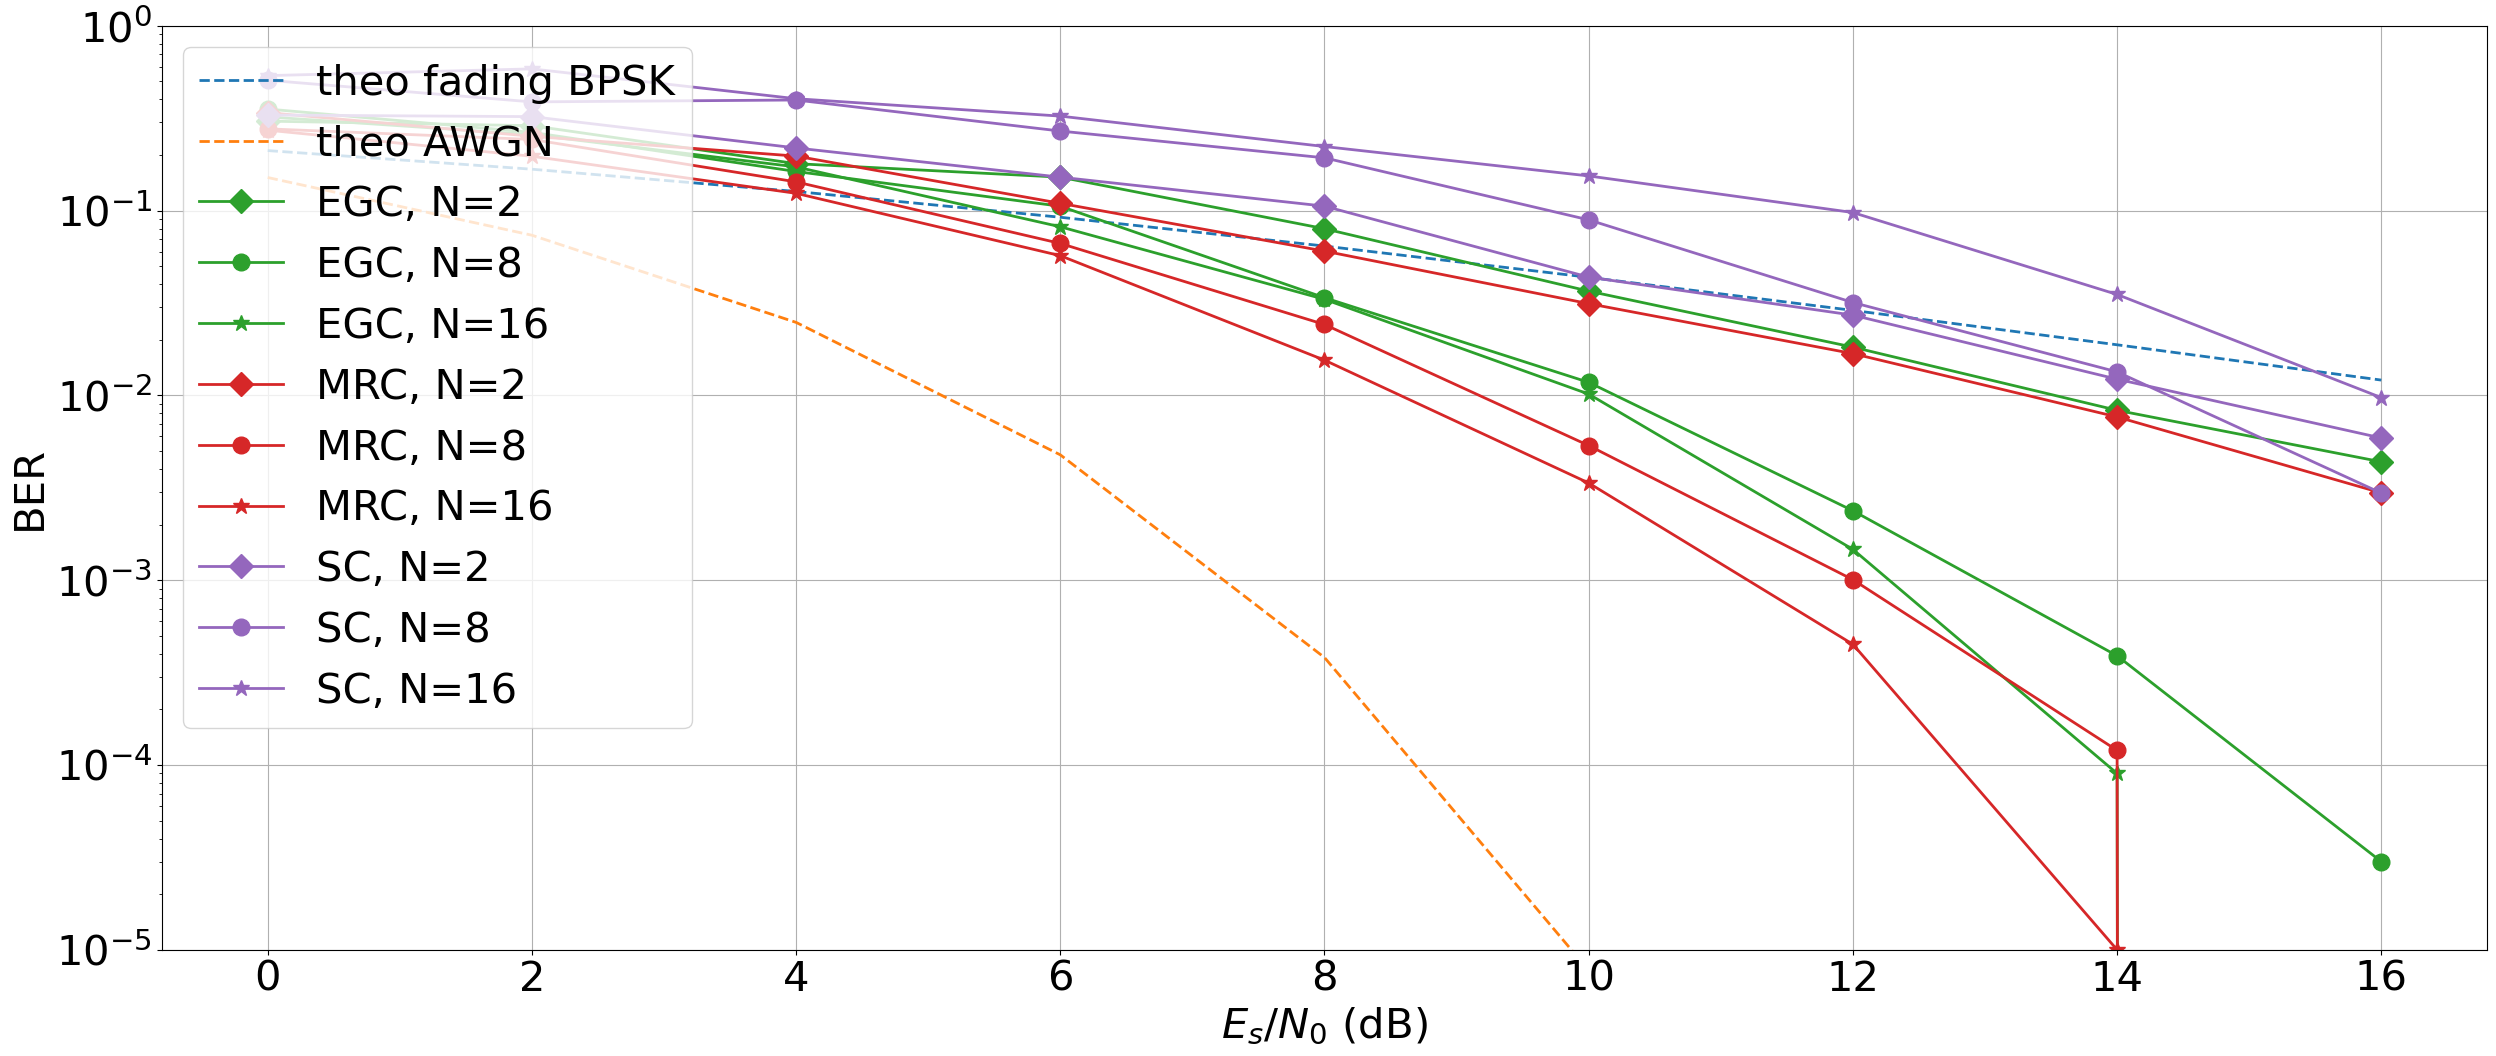

In [7]:
######################################      
# plotting
######################################    

# theoretical values
arg_Q = np.sqrt( 3. * np.log2(M) * EsN0_range / (M-1) )      
ser_theo = 1 - ( 1 - 2. * ( np.sqrt(M) - 1 ) / np.sqrt(M) * ( 1 - special.ndtr( arg_Q ) ) )**2 

ber_fade_theo = 1./2. * ( 1- np.sqrt( EsN0_range/2 /(1+EsN0_range/2)))


# plotting
plt.figure()

plt.plot(EsN0_db_range, ber_fade_theo, '--', label='theo fading BPSK', linewidth = 2.0 )
plt.plot(EsN0_db_range, ser_theo, '--', label="theo AWGN", linewidth = 2.0 )  

# loop across markes 
markers = [ 'D', 'o', '*', 's', 'v', 'p' ]

# combining methods have identical colors but alternating markers
for k in np.arange(len(comb_method)):

    if k % len(N_divs) == 0:   
        mark_ind = 0
        ax_comb = plt.plot(EsN0_db_range, ser_comb[k, :], label=comb_method[k]+", N="+str(N_div[k]), linewidth = 2.0, marker = markers[ mark_ind ], markersize = 12 )      
        color_comb = ax_comb[0].get_color()                

    else:                
        mark_ind += 1
        plt.plot(EsN0_db_range, ser_comb[k, :], label=comb_method[k]+", N="+str(N_div[k]), linewidth = 2.0, color = color_comb,  marker = markers[ mark_ind % len(markers)], markersize = 12 )


plt.yscale('log')
plt.grid(True)
plt.legend(loc='upper left') 

plt.xlabel('$E_s/N_0$ (dB)')
plt.ylabel('BER')
plt.ylim( ymin=1e-5, ymax=1e0 )
    